In [17]:
import ray
import gym
import numpy as np
import psutil
import scipy.signal
num_cpus = psutil.cpu_count(logical=False)

ray.init(num_cpus=num_cpus)

2019-09-04 22:04:56,945	WARNING worker.py:1373 -- WARNING: Not updating worker name since `setproctitle` is not installed. Install this with `pip install setproctitle` (or ray[debug]) to enable monitoring of worker processes.


Exception: Perhaps you called ray.init twice by accident? This error can be suppressed by passing in 'ignore_reinit_error=True' or by calling 'ray.shutdown()' prior to 'ray.init()'.

In [3]:
import numpy as np

In [19]:
a = np.clip(a, [0.14, -0.6, -0.1, -1, -1, -1, -1, 0], [1, 1, 1, 1, 1, 1, 1, 1])

In [10]:
import matplotlib.pyplot as plt

In [11]:
o  =np.array([[1.3460179177182152, 0.7450745544711822, 0.5315657914865674, 0.0, 0.0, 0.00369343220035989, -0.003417626362915627, -0.0027116666693854847, 8.536764749135312e-05, 3.508179345985983e-05] ,
[1.3504666489417128, 0.7702904908816586, 0.5281110061347594, 0.0, 0.0, 0.0031102109470097362, 0.022086376484265088, -0.002402447293164863, 0.0003468991729465, 0.0006533742216897447] ,
[1.35496391385967, 0.7541534637045257, 0.5246957812219172, 0.0, 0.0, 0.0032226002144896864, -0.01811862987058734, -0.0024349956161302646, 0.0013099087117213503, 0.00020630531530136067] ,
[1.359402687371338, 0.7731215012332562, 0.5212696393773045, 0.0, 0.0, 0.0031923763309123503, 0.019728904756669302, -0.0024344738565257227, 0.00014334843192321053, 0.00113804383779726] ,
[1.363909386773642, 0.7567341283747283, 0.517850114096294, 0.0, 0.0, 0.003217772966290943, -0.017851127976723544, -0.0024310907438797377, 0.0010962681434486356, 0.00018577343221520078] ,
[1.3683541764111862, 0.7742240245149783, 0.5144240535371634, 0.0, 0.0, 0.003211579314704312, 0.018415922447374986, -0.002434749280054027, 0.00019504645815529513, 0.0010846912349337747] ,
[1.3728603548073812, 0.7576957525016944, 0.5110038362781679, 0.0, 0.0, 0.003218541969873689, -0.017701790306254066, -0.002430818661179714, 0.0010900268257216874, 0.0001831021065724102] ,
[1.3773000757492344, 0.7749295066695152, 0.5075778599088105, 0.0, 0.0, 0.0032153872631436636, 0.01816355136725588, -0.0024347232708050556, 0.0001890353128973745, 0.0010724276633057967] ,
[1.3818032516164456, 0.7583712875640773, 0.504157213854347, 0.0, 0.0, 0.003219329068065043, -0.0176712724293167, -0.0024305525395715492, 0.0010778305888334287, 0.00018658250950941477] ,
[1.3862349034323078, 0.7755528550746594, 0.500731599366642, 0.0, 0.0, 0.003216365028456466, 0.018108441326664563, -0.002434699853594225, 0.0001935254592945106, 0.0010725387030029487] ,
[1.3907339806145005, 0.7589854809117916, 0.49731069811666384, 0.0, 0.0, 0.0032199765619434924, -0.01766298323434923, -0.002430274160367409, 0.0010790400710816463, 0.0001861244196549626] ,
[1.3951557122834788, 0.7761625577331043, 0.4938856879532401, 0.0, 0.0, 0.003216457889139722, 0.018098614412433493, -0.00243468598062601, 0.00019280945488081702, 0.0010716915926697582] ,
[1.3996497025463592, 0.7595909601251039, 0.4904646792290892, 0.0, 0.0, 0.003220461090176616, -0.017659912731095413, -0.0024300004295944406, 0.0010781283310383652, 0.00018669425689555114] ,
[1.4040597231162186, 0.7767696265214918, 0.4870405140674752, 0.0, 0.0, 0.0032160691599882906, 0.018095375106793942, -0.0024346875114708753, 0.00019341546461119915, 0.0010718594678141738] ,
[1.408547488344889, 0.76019468590823, 0.48361954007216856, 0.0, 0.0, 0.00322073873539046, -0.017657728712405056, -0.002429740515898914, 0.0010783341539166106, 0.00018681127464779496] ,
[1.412943647717406, 0.7773754578079447, 0.48019648226122225, 0.0, 0.0, 0.003215129548080683, 0.018093127786615093, -0.0024347052503927162, 0.00019346648559688241, 0.0010717712595261263] ,
[1.417423772434405, 0.7607974567310345, 0.47677569636560313, 0.0, 0.0, 0.0032207340994458928, -0.0176558043524846, -0.002429497107508254, 0.001078198400825879, 0.00018705836845960306] ,
[1.4218033625141135, 0.7779800763615321, 0.4733540526045267, 0.0, 0.0, 0.0032134381727839407, 0.01809109104482016, -0.002434732930538947, 0.0001936779094849323, 0.0010717884394202746] ,
[1.426274030002667, 0.7613991984795649, 0.4699336349210419, 0.0, 0.0, 0.003220328091057948, -0.01765405230538381, -0.0024292680040304895, 0.0010781849446619158, 0.00018724217237040978] ,
[1.4306335530426852, 0.7785832979219363, 0.46651378279733546, 0.0, 0.0, 0.0032106744459858526, 0.018089155940812174, -0.002434755904153677, 0.0001938079627730788, 0.0010717738395970276] ,
[1.435092368619985, 0.7619996950302625, 0.4630939585620601, 0.0, 0.0, 0.0032193320317196877, -0.017652463629289173, -0.0024290457667188697, 0.0010781249949267737, 0.00018743274840425818] ,
[1.4394271947720298, 0.779184844976307, 0.45967638352571805, 0.0, 0.0, 0.00320633423922987, 0.01808727542569439, -0.0024347471137343914, 0.00019394093274236038, 0.001071774062039544] ,
[1.4438709098403648, 0.7625986369059892, 0.4562574493996542, 0.0, 0.0, 0.0032174389187091, -0.017651040683056344, -0.002428815099234708, 0.001078074519386631, 0.0001876072056330283] ,
[1.4481747371431368, 0.7797843250757623, 0.4528428017622911, 0.0, 0.0, 0.00319959839536935, 0.018085389656160737, -0.0024346577715475166, 0.00019404561051280324, 0.0010717722509864765] ,
[1.452598795759652, 0.7631955865382835, 0.4494251681174555, 0.0, 0.0, 0.0032141287819990915, -0.017649791565081976, -0.0024285462866557744, 0.0010780102390000352, 0.00018777551163061526] ,
[1.4568627577382411, 0.7803811881464432, 0.44601435744669904, 0.0, 0.0, 0.0031890762886355424, 0.018083415936279802, -0.0024343973252303457, 0.00019413058359885345, 0.001071773626279075] ,
[1.461260511620114, 0.763789924160591, 0.4425986220760425, 0.0, 0.0, 0.0032084747997912252, -0.01764873414308485, -0.002428180144426956, 0.0010779354498721343, 0.00018793708977526838] ,
[1.4654716245031496, 0.7809746277732766, 0.4391929837127074, 0.0, 0.0, 0.003172278261122229, 0.01808120376725533, -0.002433788992276016, 0.00019418919808029988, 0.0010717747812507181] ,
[1.469832888401299, 0.7643807235056869, 0.4357800701427214, 0.0, 0.0, 0.0031987167144339147, -0.017647902202049922, -0.002427592120936768, 0.0010778411357368336, 0.00018809689756377692] ,
[1.4739711779006512, 0.7815634020349715, 0.43238167966328184, 0.0, 0.0, 0.0031444486144239507, 0.018078466904328763, -0.0024324643025028067, 0.00019421882174940942, 0.0010717729627023138] ,
[1.4782793684265585, 0.7649665197537099, 0.4289731187222462, 0.0, 0.0, 0.0031812374067149486, -0.017647364141955717, -0.0024264995434614763, 0.0010777173778233249, 0.0001882617673661393] ,
[1.4823121496449474, 0.7821454769814274, 0.42558543495693496, 0.0, 0.0, 0.0030957595641803227, 0.018074614810183808, -0.0024295903943331153, 0.00019421422287454554, 0.0010717593126953005] ,
[1.486538092644988, 0.765544825870701, 0.42218399631115966, 0.0, 0.0, 0.003147841156700101, -0.017647273372383084, -0.0024241955390490173, 0.001077544782014812, 0.00018844607819208905] ,
[1.490430391908009, 0.781926298239665, 0.41961697282649163, 0.0, 0.0, 0.0030036904601081155, 0.014841204577071661, 0.000916017732598985, -5.0161198978371496e-06, 0.005216805085651056] ,
[1.494183767896916, 0.7675201224085366, 0.41951727667027056, 0.0, 0.0, 0.002835325394393124, -0.015057515209342759, -0.0003408134226569797, 0.00974890983509078, 0.0007430958956266458] ,
[1.4973639777241903, 0.7824659510393898, 0.41952099609629717, 0.0, 0.0, 0.0024668522339611728, 0.015389830493229542, 0.0003292745269152534, 0.0006065303267078251, 0.013148051761232184] ,
[1.5007185892778396, 0.7680121120724798, 0.41949209482519534, 0.0, 0.0, 0.0026743816218847377, -0.015470738014601915, -0.0005722536125191815, 0.011518124874557478, 0.001116447983080096] ,
[1.5036036488522775, 0.7828590875706731, 0.4195373068402509, 0.0, 0.0, 0.0022598893408077568, 0.015442138073039837, 0.0004682137968181272, 0.0007937482550911687, 0.01366382539107029] ,
[1.5066794941373296, 0.7682438701082462, 0.419439467694793, 0.0, 0.0, 0.0026779804724698366, -0.014251324508385087, 0.00043415692379714365, 0.013041005959090536, 0.0009930965378756693] ,
[1.509108881813325, 0.783149565860119, 0.4195312918826538, 0.0, 0.0, 0.0018319273122846002, 0.015381224956093745, -4.93228939572544e-05, 0.0011631016382870017, 0.012889729920644388] ,
[1.5117108408328999, 0.7688895524184425, 0.4195585665836403, 0.0, 0.0, 0.002087597372244121, -0.01553932720595771, -0.0008288417067397616, 0.011497671014286675, 0.0010593996870911263] ,
[1.513311708524379, 0.7833178116077191, 0.419600714922652, 0.0, 0.0, 0.0009940829166425987, 0.014914952814371503, 0.0006018281453526944, 0.0005821479527650276, 0.012460259857200789] ,
[1.5149714499586062, 0.7689429567033554, 0.41959900150004587, 0.0, 0.0, 0.0011723448295494912, -0.014747251427210091, 0.00018313784368952164, 0.011555548522811104, 0.0008778337912009093] ,
[1.5154575186488246, 0.7836464828267523, 0.41958725148480913, 0.0, 0.0, 7.01157498063426e-05, 0.015445475118910111, -0.0002443718873251164, 0.0008539606383535263, 0.013783604477508869] ,
[1.5163740039171671, 0.7695427190673618, 0.4196188657994063, 0.0, 0.0, 0.000690945342316582, -0.014705954324079262, 0.00020422370602660305, 0.012106700317614419, 0.0010603132436593282] ,
[1.5163578485488305, 0.7844069526949299, 0.4196597031191216, 0.0, 0.0, -0.00023419790326908204, 0.015326446253015425, 0.0002342346158138645, 0.0008269767483135402, 0.01493622028469832] ,
[1.51699790562651, 0.7702053145293428, 0.41964135404344827, 0.0, 0.0, 0.0004879280308431218, -0.01495848239344815, 1.1395020571347814e-05, 0.011661869853313805, 0.0008815182805471464] ,
[1.5167901116987124, 0.7848043131512975, 0.41965020189553615, 0.0, 0.0, -0.0004411137158569198, 0.016229264027474207, -0.0004997662491109701, 0.0011116845812156534, 0.014044665019584696] ,
[1.517307448523704, 0.7708416093572197, 0.41966503318427173, 0.0, 0.0, 0.00042002468134296665, -0.014892061718046853, 0.00015291846551441693, 0.010847204898527266, 0.0007338405529894894] ,
[1.5169959436855218, 0.7854881845633829, 0.4196634639266332, 0.0, 0.0, -0.0005657600151565818, 0.016289529623320646, -0.0007089766738888492, 0.0006232804348096232, 0.014250248785143806]])

In [32]:
a

array([[ 0.14      , -0.1309648 , -0.1       , -0.4742699 , -0.32221687,
         0.3701621 ,  0.54594857,  0.        ],
       [ 0.14      ,  0.83188546, -0.1       , -0.8876345 ,  0.6840663 ,
         0.3454056 ,  0.6574286 ,  0.        ],
       [ 0.14      , -0.6       , -0.1       ,  0.7672725 ,  0.52455467,
        -0.23008887,  0.95038044,  0.        ],
       [ 0.14      ,  0.67854923, -0.1       , -0.9524706 ,  0.408383  ,
         0.90197724,  0.7510869 ,  0.        ],
       [ 0.14      , -0.6       , -0.1       ,  0.7808289 ,  0.5956413 ,
        -0.18878014,  0.95667946,  0.        ],
       [ 0.14      ,  0.6294527 , -0.1       , -0.9570568 ,  0.41307187,
         0.9212202 ,  0.79244554,  0.        ],
       [ 0.14      , -0.6       , -0.1       ,  0.78439206,  0.6098189 ,
        -0.17494386,  0.95818913,  0.        ],
       [ 0.14      ,  0.62050956, -0.1       , -0.9576741 ,  0.41364393,
         0.9239675 ,  0.7992784 ,  0.        ],
       [ 0.14      , -0.6       

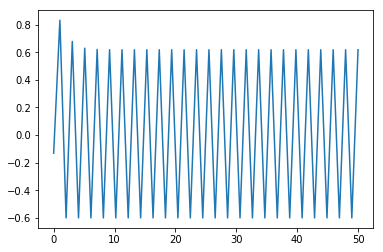

In [33]:
x = np.linspace(0,50,50)

plt.plot(x,a[:,1])

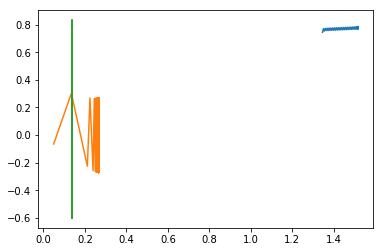

In [27]:
plt.plot(o[:,0],o[:,1])
plt.plot(o2[:,0],o2[:,1])
plt.plot(a[:,0],a[:,1])

In [41]:
import os
import time

In [47]:
for i in range(0,10,2):
    print(i)

0
2
4
6
8


In [36]:
x = np.load('collected_data/30000ultimate_pm_objectpics.npy')

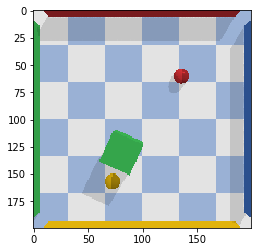

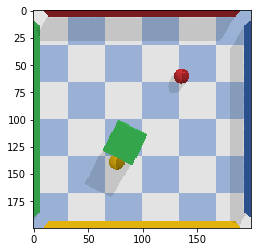

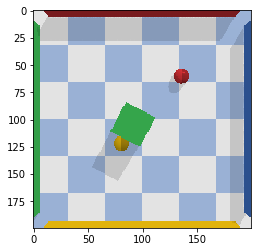

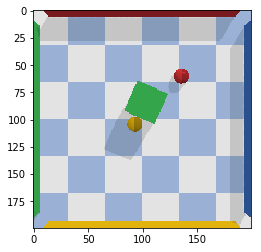

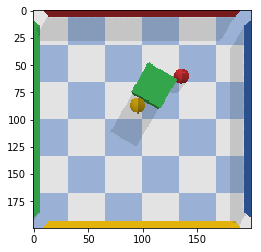

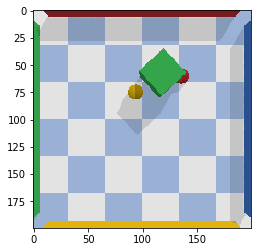

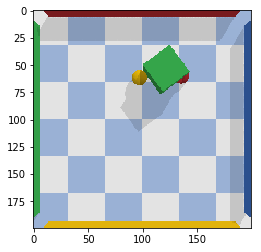

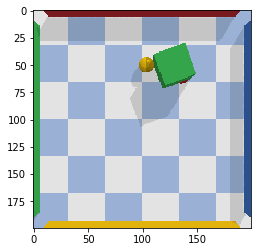

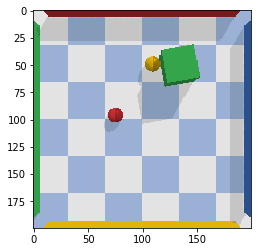

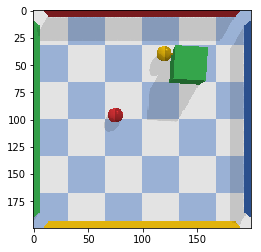

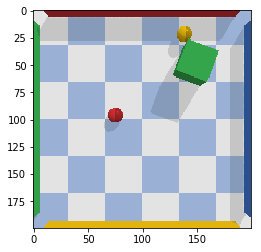

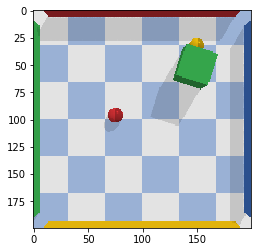

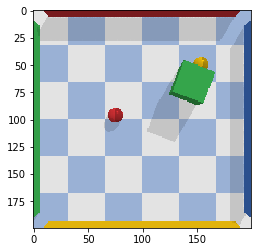

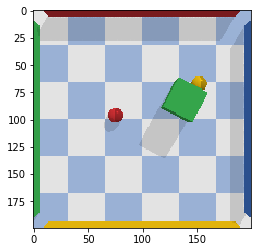

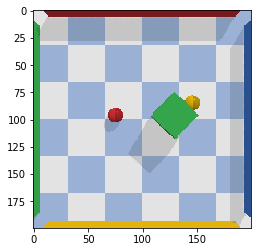

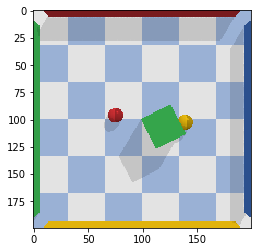

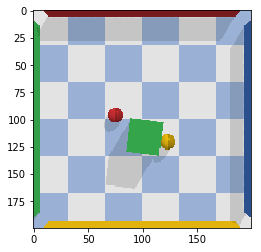

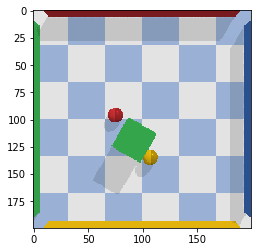

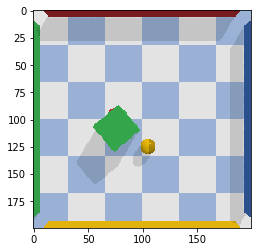

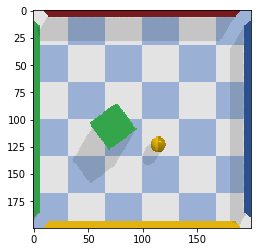

In [51]:
for i in range(500,600,5):
    plt.imshow(x[i,:,:,:], cmap = 'gray')
    plt.show()
    time.sleep(0.1)

In [15]:
o2 = np.array([[0.049234714, -0.064855464, 0.22743012, 0.10754578, 0.92546636, -0.6555814, -0.9903009, 0.013616206, 0.71134865, -0.017421743, 0.7024914, 0.066062264, -2.0780945, -1.5119131, -1.1644427, 1.5664939, 0.10840249, 0.004301831, -0.004301831] ,
[0.1346478, 0.30250207, 0.17298889, 0.038553648, -0.3369383, 2.9139864, -0.52324456, 0.015454934, 0.708846, -0.015635043, 0.7050206, 0.54379684, -2.4560728, -1.0100232, -1.2799958, 1.573617, 0.5861707, 0.001542146, -0.001542146] ,
[0.21179995, -0.22511865, 0.14416751, 0.50603706, -0.9160571, -4.060962, -0.21467479, 0.0129237855, 0.70735276, -0.018082652, 0.7065112, -0.15892841, -2.6101577, -0.79095864, -1.3406733, 1.5631019, -0.1166696, 0.020241482, -0.020241482] ,
[0.22428235, 0.26843673, 0.13418737, 0.18140715, -1.1057749, 3.6589587, -0.072123356, 0.015516574, 0.708057, -0.0154666295, 0.7058153, 0.46075112, -2.702841, -0.6328757, -1.4087602, 1.5725529, 0.50297594, 0.007256286, -0.007256286] ,
[0.23922378, -0.2581275, 0.13089111, 0.5659447, -1.1920844, -3.8554792, -0.024008086, 0.012896784, 0.70803165, -0.018039461, 0.7058324, -0.19060066, -2.7495599, -0.54817826, -1.445807, 1.5628527, -0.14843303, 0.022637786, -0.022637784] ,
[0.24515544, 0.26564252, 0.13032746, 0.20288318, -1.2254776, 3.8166654, -0.0048470804, 0.015191314, 0.7086851, -0.015740642, 0.7051857, 0.44830146, -2.7891076, -0.4694888, -1.4878772, 1.572533, 0.49045298, 0.008115327, -0.008115327] ,
[0.24992374, -0.26493335, 0.13040103, 0.57592934, -1.2514548, -3.852769, -0.00048987515, 0.013002813, 0.7086606, -0.017903905, 0.70520246, -0.1959001, -2.8112679, -0.42493314, -1.5091069, 1.5629036, -0.15376633, 0.023037175, -0.023037171] ,
[0.25317293, 0.2668291, 0.13076073, 0.20646256, -1.2616698, 3.8574347, 0.0016904158, 0.014995874, 0.70912397, -0.015915873, 0.70474464, 0.4458467, -2.835093, -0.37525642, -1.5374643, 1.5725864, 0.48796868, 0.008258503, -0.008258501] ,
[0.25544602, -0.2671552, 0.13106976, 0.577307, -1.2728364, -3.8680816, 0.0012485286, 0.01307582, 0.70903134, -0.017818935, 0.70483047, -0.19722736, -2.8485506, -0.34756196, -1.5502491, 1.5629537, -0.15510605, 0.02309228, -0.023092274] ,
[0.2573317, 0.26792306, 0.13136481, 0.20695645, -1.2776939, 3.874549, 0.0013468964, 0.014882549, 0.709386, -0.01602011, 0.70448095, 0.44505152, -2.8653476, -0.31215543, -1.571108, 1.5726246, 0.48715994, 0.008278257, -0.0082782535] ,
[0.25870445, -0.2682557, 0.13160244, 0.5774304, -1.2831364, -3.880125, 0.00084204297, 0.013121756, 0.7092565, -0.017767448, 0.70460445, -0.19778296, -2.8746116, -0.29309335, -1.5792994, 1.5629861, -0.15566687, 0.023097217, -0.02309721] ,
[0.2598551, 0.2686679, 0.13178927, 0.2070007, -1.2864169, 3.884446, 0.0006669955, 0.014811332, 0.70955175, -0.016086504, 0.70431393, 0.44465038, -2.8874047, -0.26603183, -1.5956795, 1.5726489, 0.48675147, 0.008280028, -0.008280022] ,
[0.26080188, -0.26893088, 0.13196357, 0.57742506, -1.2889888, -3.8884892, 0.00046489012, 0.013152208, 0.7094043, -0.017734027, 0.70445585, -0.19810398, -2.8942673, -0.2519881, -1.6011723, 1.563007, -0.15599038, 0.023097003, -0.023096995] ,
[0.26152432, 0.26917395, 0.1320776, 0.2069988, -1.2917621, 3.8910096, 0.00020975535, 0.01476288, 0.7096646, -0.016132053, 0.70420027, 0.44439894, -2.9044616, -0.23036836, -1.6146303, 1.572665, 0.48649555, 0.008279951, -0.008279945] ,
[0.26223576, -0.2693867, 0.13221242, 0.5774188, -1.2926625, -3.8943763, 0.00023609861, 0.01317361, 0.7095081, -0.017710859, 0.7043514, -0.19831671, -2.9098034, -0.21951033, -1.6184115, 1.5630213, -0.1562044, 0.023096753, -0.023096744] ,
[0.26269004, 0.26952988, 0.13227983, 0.20699656, -1.2952921, 3.8956416, -7.9522266e-05, 0.014727865, 0.70974594, -0.016165167, 0.70411825, 0.44422626, -2.918172, -0.20171417, -1.629823, 1.5726762, 0.4863199, 0.008279862, -0.008279854] ,
[0.26325887, -0.26971066, 0.13239016, 0.5774167, -1.2951252, -3.8986423, 0.000100645484, 0.0131893605, 0.70958483, -0.01769398, 0.70427436, -0.19846678, -2.922484, -0.19301312, -1.6324483, 1.5630314, -0.1563552, 0.02309667, -0.023096658] ,
[0.26353517, 0.2697886, 0.1324266, 0.2069958, -1.2977461, 3.8990314, -0.00026807113, 0.014701423, 0.70980716, -0.016190289, 0.7040565, 0.44410193, -2.9294975, -0.17805295, -1.6423463, 1.5726842, 0.4861935, 0.008279832, -0.008279825] ,
[0.264012, -0.2699487, 0.13252111, 0.5774162, -1.2968546, -3.901814, 1.8110892e-05, 0.013201362, 0.70964354, -0.017681219, 0.7042152, -0.19857658, -2.9330764, -0.17088635, -1.6441513, 1.5630388, -0.15646541, 0.023096647, -0.023096636] ,
[0.26416484, 0.2699816, 0.13253613, 0.2069956, -1.2995161, 3.9015753, -0.00039568718, 0.014680792, 0.7098547, -0.016209964, 0.7040085, 0.44400966, -2.9390423, -0.15811703, -1.6528833, 1.5726901, 0.48609975, 0.008279825, -0.008279815] ,
[0.26457945, -0.2701278, 0.13261995, 0.57741594, -1.2981112, -3.9042208, -3.3774002e-05, 0.013210753, 0.70968986, -0.017671302, 0.7041687, -0.19865899, -2.9420786, -0.15208572, -1.6540825, 1.5630443, -0.15654802, 0.02309664, -0.023096628] ,
[0.26464364, 0.27012846, 0.13261962, 0.20699555, -1.3008283, 3.9035206, -0.00048482968, 0.014664289, 0.70989263, -0.016225757, 0.70397025, 0.44393972, -2.9472094, -0.1410628, -1.6618869, 1.5726947, 0.48602864, 0.008279822, -0.0082798125] ,
[0.26501465, -0.27026504, 0.13269596, 0.57741594, -1.2990481, -3.9060762, -6.7187575e-05, 0.013218254, 0.7097271, -0.017663427, 0.7041312, -0.19872198, -2.949831, -0.13589872, -1.6626242, 1.5630486, -0.15661113, 0.023096638, -0.023096627] ,
[0.2650135, 0.27024198, 0.13268435, 0.20699553, -1.3018217, 3.9050298, -0.0005486343, 0.014650829, 0.7099234, -0.016238675, 0.7039392, 0.44388574, -2.954279, -0.12630253, -1.6696723, 1.5726982, 0.48597383, 0.008279822, -0.0082798125] ,
[0.26535296, -0.27037168, 0.13275528, 0.57741594, -1.2997605, -3.907524, -8.905433e-05, 0.013224346, 0.7097576, -0.017657064, 0.7041005, -0.19877082, -2.9565752, -0.12181879, -1.6700476, 1.5630518, -0.15666, 0.023096638, -0.023096627] ,
[0.2653027, 0.2703308, 0.13273518, 0.20699553, -1.3025858, 3.9062135, -0.0005951536, 0.01463968, 0.7099488, -0.016249405, 0.7039136, 0.44384363, -2.9604542, -0.11341111, -1.6764666, 1.572701, 0.48593104, 0.008279822, -0.0082798125] ,
[0.26561886, -0.2704554, 0.13280211, 0.57741594, -1.3003107, -3.9086652, -0.00010347681, 0.01322936, 0.70978296, -0.017651852, 0.704075, -0.19880912, -2.9624894, -0.109473124, -1.6765519, 1.5630544, -0.1566983, 0.023096638, -0.023096627] ,
[0.265531, 0.2704009, 0.13277553, 0.20699555, -1.303181, 3.9071507, -0.0006295368, 0.014630327, 0.70996994, -0.01625843, 0.70389223, 0.4438104, -2.9658868, -0.102071114, -1.6824392, 1.5727031, 0.48589727, 0.008279822, -0.0082798125] ,
[0.2658296, -0.2705217, 0.13283944, 0.57741594, -1.3007408, -3.9095714, -0.00011298376, 0.013233533, 0.70980424, -0.017647535, 0.7040536, -0.19883941, -2.9677083, -0.09857929, -1.6822877, 1.5630565, -0.15672855, 0.023096638, -0.023096627] ,
[0.26571262, 0.2704567, 0.13280782, 0.20699555, -1.3036493, 3.9078977, -0.0006552019, 0.0146224005, 0.7099878, -0.016266096, 0.70387423, 0.443784, -2.9706933, -0.092039, -1.68772, 1.5727048, 0.48587042, 0.008279822, -0.008279812] ,
[0.2659977, -0.27057457, 0.13286941, 0.57741594, -1.3010805, -3.9102957, -0.00011917984, 0.0132370405, 0.70982224, -0.017643921, 0.7040354, -0.19886352, -2.9723375, -0.088917844, -1.687372, 1.5630581, -0.15675262, 0.023096638, -0.023096627] ,
[0.265858, 0.27050138, 0.13283385, 0.20699555, -1.3040205, 3.9084966, -0.0006744857, 0.014615622, 0.710003, -0.016272664, 0.70385885, 0.44376287, -2.974965, -0.0831235, -1.6924106, 1.5727061, 0.48584893, 0.008279822, -0.008279812] ,
[0.2661326, -0.27061695, 0.13289364, 0.57741594, -1.3013506, -3.9108772, -0.00012311469, 0.0132400105, 0.7098377, -0.017640874, 0.70401984, -0.19888283, -2.97646, -0.08031454, -1.6918972, 1.5630594, -0.15677185, 0.023096638, -0.023096627] ,
[0.26597494, 0.2705373, 0.13285497, 0.20699555, -1.3043168, 3.9089792, -0.0006890282, 0.014609786, 0.710016, -0.016278332, 0.70384574, 0.44374588, -2.9787755, -0.07517129, -1.6965927, 1.5727073, 0.48583168, 0.008279822, -0.008279812] ,
[0.26624128, -0.27065107, 0.1329133, 0.57741594, -1.3015668, -3.9113462, -0.00012548892, 0.013242543, 0.70985097, -0.017638285, 0.7040065, -0.19889838, -2.980143, -0.072628394, -1.6959383, 1.5630604, -0.1567873, 0.023096638, -0.023096627] ,
[0.26606935, 0.27056628, 0.13287216, 0.20699555, -1.3045542, 3.909369, -0.0007000062, 0.014604728, 0.7100273, -0.016283255, 0.70383435, 0.44373217, -2.9821844, -0.068057306, -1.7003325, 1.5727081, 0.48581773, 0.008279822, -0.008279812] ,
[0.26632914, -0.27067867, 0.13292937, 0.57741594, -1.3017409, -3.9117253, -0.00012677864, 0.013244716, 0.7098625, -0.017636074, 0.7039949, -0.1989109, -2.9834423, -0.065743394, -1.6995571, 1.5630612, -0.15679976, 0.023096638, -0.023096627] ,
[0.26614586, 0.2705898, 0.13288623, 0.20699555, -1.3047453, 3.9096851, -0.0007082803, 0.014600323, 0.71003705, -0.016287548, 0.7038245, 0.44372106, -2.9852417, -0.061677903, -1.703685, 1.5727088, 0.48580644, 0.008279822, -0.008279812] ,
[0.2664004, -0.270701, 0.13294253, 0.57741594, -1.3018816, -3.9120328, -0.00012731472, 0.01324659, 0.7098724, -0.017634172, 0.70398486, -0.19892104, -2.9864042, -0.059562743, -1.7028046, 1.563062, -0.15680982, 0.023096638, -0.023096627] ,
[0.266208, 0.2706089, 0.1328978, 0.20699555, -1.3048997, 3.9099422, -0.00071448775, 0.014596467, 0.7100455, -0.016291313, 0.70381594, 0.44371203, -2.9879885, -0.055946037, -1.7066964, 1.5727094, 0.48579723, 0.008279822, -0.008279812] ,
[0.26645827, -0.27071914, 0.13295333, 0.57741594, -1.3019956, -3.9122827, -0.0001273294, 0.0132482145, 0.7098812, -0.017632531, 0.70397604, -0.19892927, -2.9890678, -0.054004613, -1.7057241, 1.5630625, -0.15681797, 0.023096638, -0.023096627] ,
[0.2662586, 0.27062443, 0.13290732, 0.20699555, -1.3050246, 3.9101515, -0.00071910815, 0.014593079, 0.71005297, -0.016294627, 0.7038084, 0.44370466, -2.9904606, -0.05078776, -1.7094057, 1.5727099, 0.48578975, 0.008279822, -0.008279812] ,
[0.26650542, -0.2707339, 0.13296226, 0.57741594, -1.3020884, -3.912486, -0.00012698575, 0.013249627, 0.7098888, -0.017631108, 0.70396835, -0.19893594, -2.9914668, -0.048999127, -1.7083527, 1.563063, -0.15682459, 0.023096638, -0.023096627] ,
[0.26629984, 0.2706371, 0.1329152, 0.20699555, -1.3051261, 3.9103222, -0.0007225068, 0.014590093, 0.71005946, -0.01629755, 0.7038019, 0.44369867, -2.9926882, -0.046139617, -1.7118465, 1.5727103, 0.48578364, 0.008279822, -0.008279812] ,
[0.26654387, -0.27074593, 0.13296963, 0.57741594, -1.3021641, -3.9126518, -0.00012640236, 0.01325086, 0.70989555, -0.01762987, 0.70396155, -0.19894138, -2.9936297, -0.044486027, -1.7107222, 1.5630634, -0.15682995, 0.023096638, -0.023096627] ,
[0.26633352, 0.27064744, 0.13292171, 0.20699555, -1.3052083, 3.9104617, -0.00072496245, 0.014587452, 0.71006525, -0.016300142, 0.703796, 0.44369376, -2.9946978, -0.041946664, -1.7140478, 1.5727106, 0.48577866, 0.008279822, -0.008279812] ,
[0.26657528, -0.27075574, 0.13297574, 0.57741594, -1.3022258, -3.912787, -0.00012566343, 0.013251942, 0.7099015, -0.017628787, 0.70395553, -0.1989458, -2.9955819, -0.040412944, -1.7128602, 1.5630636, -0.1568343, 0.023096638, -0.023096627] ,
[0.2663611, 0.2706559, 0.13292713, 0.20699555, -1.3052753, 3.9105759, -0.00072669145, 0.01458511, 0.7100703, -0.01630244, 0.7037909, 0.44368976, -2.996512, -0.038161006, -1.7160349, 1.5727109, 0.48577458, 0.008279822, -0.008279812] ,
[0.26660094, -0.27076373, 0.13298082, 0.57741594, -1.3022764, -3.9128973, -0.00012482984, 0.013252892, 0.7099068, -0.017627839, 0.7039502, -0.19894941, -2.997345, -0.036734056, -1.714791, 1.5630639, -0.15683785, 0.023096638, -0.023096627] ,
[0.26638362, 0.2706628, 0.13293165, 0.20699555, -1.3053299, 3.9106693, -0.00072785997, 0.01458303, 0.71007484, -0.016304485, 0.7037864, 0.4436865, -2.9981513, -0.0347406, -1.7178301, 1.5727111, 0.48577124, 0.008279822, -0.008279812]])

(50, 19)

In [4]:


num_tasks = 12

@ray.remote
def f(image, random_filter):
    # Do some image processing.
    return scipy.signal.convolve2d(image, random_filter)[::5, ::5]

filters = [np.random.normal(size=(4, 4)) for _ in range(num_tasks)]

# Time the code below.
def test():
    for _ in range(10):
        image = np.zeros((3000, 3000))
        image_id = ray.put(image)
        ray.get([f.remote(image_id, filters[i]) for i in range(num_tasks)])
        
%time test()

CPU times: user 1.25 s, sys: 2.43 s, total: 3.69 s
Wall time: 25.7 s


In [5]:
from multiprocessing import Pool
import numpy as np
import psutil
import scipy.signal

num_cpus = psutil.cpu_count(logical=False)

def f(args):
    image, random_filter = args
    # Do some image processing.
    return scipy.signal.convolve2d(image, random_filter)[::5, ::5]

pool = Pool(num_cpus)

filters = [np.random.normal(size=(4, 4)) for _ in range(num_tasks)]

# Time the code below.

def test():
    for _ in range(10):
        image = np.zeros((3000, 3000))
        pool.map(f, zip(num_tasks * [image], filters))
%time test()

CPU times: user 8.37 s, sys: 9.47 s, total: 17.8 s
Wall time: 43.2 s


In [61]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D,Bidirectional, LSTM, Dropout
from tensorflow.keras import Model
import tensorflow as tf
class MLP(Model):
    def __init__(self, LAYER_SIZE, OUTPUT_SIZE):
        super(MLP, self).__init__()
        
        self.d1 = Dense(LAYER_SIZE, activation='relu')
        self.d2 = Dense(LAYER_SIZE, activation='relu')
        self.d3 = Dense(OUTPUT_SIZE, activation = 'tanh')

    def call(self, x, acts=None, training=False):
        
        x = self.d1(x)
        x = self.d2(x)
        x = self.d3(x)
        return x

model = MLP(12, 5)
model2 = MLP(13,4)
model(np.ones([10,12]))

<tf.Tensor: id=15455, shape=(10, 5), dtype=float64, numpy=
array([[ 0.05062235,  0.14818228, -0.32560839,  0.41634638, -0.04870811],
       [ 0.05062235,  0.14818228, -0.32560839,  0.41634638, -0.04870811],
       [ 0.05062235,  0.14818228, -0.32560839,  0.41634638, -0.04870811],
       [ 0.05062235,  0.14818228, -0.32560839,  0.41634638, -0.04870811],
       [ 0.05062235,  0.14818228, -0.32560839,  0.41634638, -0.04870811],
       [ 0.05062235,  0.14818228, -0.32560839,  0.41634638, -0.04870811],
       [ 0.05062235,  0.14818228, -0.32560839,  0.41634638, -0.04870811],
       [ 0.05062235,  0.14818228, -0.32560839,  0.41634638, -0.04870811],
       [ 0.05062235,  0.14818228, -0.32560839,  0.41634638, -0.04870811],
       [ 0.05062235,  0.14818228, -0.32560839,  0.41634638, -0.04870811]])>

In [4]:
@ray.remote
class Person:
  def __init__(self):
    pass

    
  def test(self,weight):
        return weight.shape
    
  def ez(self):
        return 5



In [5]:
actor = Person.remote()

In [7]:
ray.get(actor.test.remote(model.trainable_variables[0].numpy()))

(12, 12)

In [ ]:
ray.get(actor.test.remote(model.trainable_variables[0]))

2019-09-04 18:03:28,762	WARNING worker.py:352 -- WARNING: Falling back to serializing objects of type <enum 'VariableSynchronization'> by using pickle. This may be inefficient.
2019-09-04 18:03:28,775	WARNING worker.py:352 -- WARNING: Falling back to serializing objects of type <enum 'VariableAggregation'> by using pickle. This may be inefficient.


In [11]:
tf.compat.v1.assign(model.trainable_variables[0], np.ones((12,12)))

<tf.Variable 'UnreadVariable' shape=(12, 12) dtype=float64, numpy=
array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])>

In [14]:
[n.numpy() for n in model.trainable_variables]

[array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([[-1.42202652e-01,  3.47808911e-01,  9.59553275e-02,
          1.66138875e-01, -5.82863090e-03, -4.29771430e-01,
          3.76412865e-01,  1.05054466e-02,  2.65030418e-01,
          1.19525392e-01, -3.56003166e-01, -3.52443089e-01],
   

In [15]:
x = []
x.append([n.numpy() for n in model.trainable_variables])

In [20]:
model.trainable_variables[0]+2

<tf.Tensor: id=146, shape=(12, 12), dtype=float64, numpy=
array([[3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.]])>

In [56]:
model.trainable_variables

[<tf.Variable 'mlp/dense/kernel:0' shape=(12, 12) dtype=float64, numpy=
 array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])>,
 <tf.Variable 'mlp/dense/bias:0' shape=(12,) dtype=float64, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])>,
 <tf.Variable 'mlp/dense_1/kernel:0' shape=(12, 12) dtype=float64, numpy=
 array([[-1.42202652e-01,  3.47

In [69]:
x = model.trainable_variables
y = [i+1 for i in model.trainable_variables]
z = [i-1 for i in model.trainable_variables]


x2 = model2.trainable_variables
y2 = [i+1 for i in model2.trainable_variables]
z2 = [i-1 for i in model2.trainable_variables]

In [63]:
weights = [[x,x2], [y,y2], [z,z2]]
by_models = zip(*weights)


In [67]:
weights = [['a',2], ['b',3], ['c',8]]
for q in zip(*weights):
    print(q)

('a', 'b', 'c')
(2, 3, 8)


In [60]:

[np.sum(w)/len(w) for w in zip(*[x])]

[<tf.Tensor: id=14884, shape=(12, 12), dtype=float64, numpy=
 array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])>,
 <tf.Tensor: id=14887, shape=(12,), dtype=float64, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])>,
 <tf.Tensor: id=14890, shape=(12, 12), dtype=float64, numpy=
 array([[-1.42202652e-01,  3.47808911e-01,  9.59553275e-02,
    

In [83]:
d = {'ok':5}
d.copy()

{'ok': 5}

In [75]:
np.sum((np.expand_dims(x[0].numpy(), 0),), axis = 0)

array([[[ 0.3973526 ,  0.23372644, -0.16991816, -0.47508506,
         -0.25340132, -0.31434749,  0.36006794, -0.28112358,
          0.00555293,  0.20267567,  0.14065435,  0.04354843],
        [-0.38942335,  0.46742368,  0.46361934,  0.22871681,
          0.14772727,  0.29518396,  0.16449136,  0.10679124,
          0.0120779 , -0.06643967, -0.25144239, -0.08196039],
        [ 0.42249216, -0.25546421,  0.16359994, -0.29694118,
         -0.12504064, -0.37510743, -0.26868091, -0.35480439,
          0.10558946,  0.07322366,  0.04522533, -0.17068743],
        [-0.42908809,  0.40899685, -0.1491241 , -0.07867091,
         -0.23094486,  0.20849508, -0.21904857, -0.20920019,
          0.44698554,  0.2427562 , -0.33457385, -0.28715636],
        [ 0.49086107, -0.42783939,  0.27332596, -0.47542985,
          0.32009296, -0.24447311, -0.19043995, -0.11937856,
         -0.05637138,  0.08062986,  0.25294316,  0.13309879],
        [ 0.4787761 ,  0.30332286,  0.24253408, -0.09815372,
          0.0513895

In [57]:
l = [x,y,z]



[np.sum(w)/len(w) for w in zip(*l)]

[<tf.Tensor: id=13398, shape=(12, 12), dtype=float64, numpy=
 array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])>,
 <tf.Tensor: id=13403, shape=(12,), dtype=float64, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])>,
 <tf.Tensor: id=13408, shape=(12, 12), dtype=float64, numpy=
 array([[-1.42202652e-01,  3.47808911e-01,  9.59553275e-02,
    

In [ ]:
import numpy as np
import tensorflow as tf
import gym
import time
import pybullet
import reach2D
from SAC import *
from train import *

SyntaxError: can't use starred expression here (cell_name, line 5)

In [ ]:
class mlp_gail_discriminator(Model):

  def __init__(self, hidden_sizes=[32,32,32], activation = 'relu'):
    super(mlp_gail_discriminator, self).__init__()
    self.mlp = mlp(list(hidden_sizes), activation, activation)
    self.prob = Dense(1, activation='sigmoid')


  def call(self, obs, acts):
    x = tf.concat([obs,acts], axis = -1)
    x = self.mlp(x)
    prob = self.prob(x)
    return prob



In [ ]:
def discriminator_train_step(batch, expert_batch,  discriminator, discriminator_optimizer):
    batch_obs, batch_acts = batch['obs1'], batch['acts']
    batch_expert_obs, batch_expert_acts = expert_batch['obs'], expert_batch['acts']
    with tf.GradientTape() as tape:
        # We'd like to maximise the log probability of the expert actions, and minmise log prob of generated actions.
        expert_probs = discriminator(batch_expert_obs,batch_expert_acts)
        # in ML, we take gradient to minimise, therefore minimise negative log probability 
        expert_loss = -tf.math.log(expert_probs)
        agent_probs = discriminator(batch_obs,batch_acts)
        # i.e, minimise -log(1-prob_generated_is_true)
        agent_loss = -(tf.math.log(1-agent_probs))
        # and thus, the reward our SAC agent gets will be -(tf.math.log(1-agent_probs)), it is trying to maximise this, 
        # discriminator is trying to mimise it.
        loss = tf.reduce_sum(expert_loss + agent_loss)
        expert_accuracy = tf.reduce_mean(tf.cast(expert_probs > 0.5, tf.float32))
        agent_accuracy  = tf.reduce_mean(tf.cast(agent_probs < 0.5, tf.float32))


        
    gradients = tape.gradient(loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients, discriminator.trainable_variables))
    return loss.numpy(), expert_accuracy.numpy(), agent_accuracy.numpy()

In [ ]:
expert_obs = np.load('collected_data/expert_obs_Pendulum-v0_Hidden_32l_25000.npy')
expert_acts = np.load('collected_data/expert_actions_Pendulum-v0_Hidden_32l_25000.npy')

def sample_expert_transitions(batch_size):
    idxs = np.random.randint(0, len(expert_obs), size=batch_size)
    return {'obs':expert_obs[idxs], 'acts':expert_acts[idxs]}

In [ ]:
def gail_run(discrim_req_acc):
    ENV_NAME='Pendulum-v0'
    env_fn = lambda : gym.make(ENV_NAME)
    hid =128
    l=2
    gamma=0.999
    steps_per_epoch=5000
    seed=0
    epochs=7
    max_ep_len = 200 # for reacher, 1000 for not. 
    exp_name = ENV_NAME+'_Hidden_'+str(hid)+'l_'+str(l)
    alpha=0.2
    batch_size=100
    lr=1e-3
    start_steps=5000 
    save_freq=1
    load = False
    render = False
    polyak=0.995
    replay_size=int(1e6)
    ac_kwargs = {}
    ac_kwargs['hidden_sizes'] = [hid]*l
    discrim_req_acc = discrim_req_acc
    tf.random.set_seed(seed)
    np.random.seed(seed)
    env, test_env = env_fn(), env_fn()
    # Get Env dimensions
    obs_dim = env.observation_space.shape[0]
    act_dim = env.action_space.shape[0]
    SAC = SAC_model(env, obs_dim, act_dim, ac_kwargs['hidden_sizes'],lr, gamma, alpha, polyak,  load, exp_name)
    # Experience buffer
    replay_buffer = ReplayBuffer(obs_dim=obs_dim, act_dim=act_dim, size=replay_size)

    #Logging 
    start_time = time.time()
    train_log_dir = 'logs/' + str(discrim_req_acc)+exp_name+':'+str(start_time)
    summary_writer = tf.summary.create_file_writer(train_log_dir)

    discriminator = mlp_gail_discriminator()
    discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    def update_models(model, replay_buffer, steps, batch_size):
        agent_accuracy = 0
        # until the discriminator is trained to sufficiently distinguish correct transitions.
        print('Updating Discriminator')
        while agent_accuracy < discrim_req_acc or expert_acurracy < discrim_req_acc:
            batch = replay_buffer.sample_batch(batch_size)
            expert_batch = sample_expert_transitions(batch_size)
            _,expert_acurracy,agent_accuracy = discriminator_train_step(batch, expert_batch, discriminator, discriminator_optimizer)
            print(expert_acurracy, agent_accuracy)

        # now update SAC
        print('Updating Policy')
        for j in range(steps):
            batch = replay_buffer.sample_batch(batch_size)
            batch_obs, batch_acts = batch['obs1'], batch['acts']
            agent_probs = discriminator(batch_obs,batch_acts)
            agent_reward = -(tf.math.log(1-agent_probs)).numpy().squeeze().astype('float32')
            # use GAIL reward instead of environment reward
            batch['rews'] = agent_reward

            LossPi, LossQ1, LossQ2, LossV, Q1Vals, Q2Vals, VVals, LogPi = model.train_step(batch)


    # now collect epsiodes
    total_steps = steps_per_epoch * epochs
    steps_collected = 0

    # collect some initial random steps to initialise
    random_steps = 5000
    steps_collected  += rollout_trajectories(n_steps = random_steps,env = env, max_ep_len = max_ep_len, actor = 'random', replay_buffer = replay_buffer, summary_writer = summary_writer)


    update_models(SAC, replay_buffer, steps = random_steps, batch_size = batch_size)

    # now act with our actor, and alternately collect data, then train.
    while steps_collected < total_steps:
    # collect an episode
        steps_collected  += rollout_trajectories(n_steps = max_ep_len,env = env, max_ep_len = max_ep_len, actor = SAC.get_action, replay_buffer = replay_buffer, summary_writer=summary_writer, current_total_steps = steps_collected)
        # take than many training steps
        update_models(SAC, replay_buffer, steps = max_ep_len, batch_size = batch_size)

        # if an epoch has elapsed, save and test.
        if steps_collected  > 0 and steps_collected  % steps_per_epoch == 0:
            #SAC.save_weights()
            # Test the performance of the deterministic version of the agent.
            rollout_trajectories(n_steps = max_ep_len*10,env = test_env, max_ep_len = max_ep_len, actor = SAC.get_deterministic_action, summary_writer=summary_writer, current_total_steps = steps_collected, train = False, render = True)


In [ ]:
test_accs = [0.6, 0.7, 0.8, 0.9]
for a in test_accs:
    gail_run(a)

In [6]:
d = {'ok':5, 'cu':78}
for k,v in d.items():
    print(k,v)

ok 5
cu 78


In [9]:
for i, (k,v) in enumerate(d.items()):
    print(i,k,v)

0 ok 5
1 cu 78


In [ ]:
# Okay, we need to do two ablations.
# Whats the optimal accuracy that we want our discriminator to have before we train? It'll be different on every problem
# but lets see if changing it on this simple problem can give us some ideas of what will happen.

# How 

In [ ]:
batch_size = 100
expert_batch = sample_expert_transitions(batch_size)
batch_expert_obs, batch_expert_acts = expert_batch['obs'], expert_batch['acts']
expert_probs = discriminator(batch_expert_obs,batch_expert_acts)


agent_reward = -(tf.math.log(1-expert_probs)).numpy().squeeze().astype('float32')
agent_reward

In [ ]:
discriminator = mlp_gail_discriminator()


In [ ]:
-(tf.math.log(0.0)).numpy()

In [ ]:
-(tf.math.log(1-0.01)).numpy()

In [ ]:
import matplotlib.pyplot as plt
xs = np.linspace(0,1,100)

In [ ]:
def f(x):
    return -(tf.math.log(1-x+1e-8)).numpy()

In [ ]:
ys = [f(x) for x in xs]

In [ ]:
plt.plot(xs,ys)

In [ ]:
def f2(x):
    return (tf.math.log(x+1e-8)-(tf.math.log(1-x+1e-8)).numpy())
ys = [f2(x) for x in xs]
plt.plot(xs,ys)

In [ ]:
def f3(x):
    return tf.math.log(x+1e-8).numpy()
ys = [f3(x) for x in xs]
plt.plot(xs,ys)

In [ ]:
x = np.linspace(1,100,100)


In [ ]:
np.delete(x, [1,2,3])

In [ ]:
a = tf.ones((100,1))
a = a.numpy().squeeze()

In [18]:
ray.shutdown()

In [ ]:
q[.shapeq

In [ ]:
a = np.array([11,21,31])

In [ ]:
b = np.array([1,2])

In [ ]:
a[b]

In [ ]:
5 % 1000

In [ ]:
tf.tensor([np.ones(100)])

In [ ]:
env

In [ ]:
env.action_space

In [ ]:
env = gym.make('Pendulum-v0')

In [ ]:
env.reset()

In [ ]:
env.step(1)

In [ ]:
a